In [1]:
%pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


Note: you may need to restart the kernel to use updated packages.


In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # image size after resize
patch_size = 16  # Size of the patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim,]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
data_augment = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augment",
)
# Compute the mean and the variance of the training data for normalization.
data_augment.layers[0].adapt(x_train)

2022-07-18 14:14:20.990147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-18 14:14:20.991833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2e:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-18 14:14:20.996198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-18 14:14:20.996489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2e:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-18 14:14:20.996730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not op

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


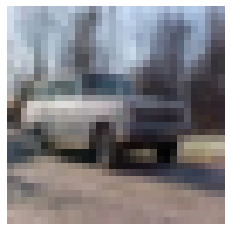

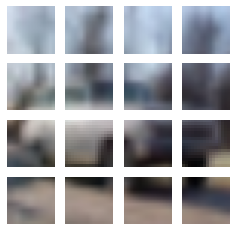

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [9]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augment(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [10]:
results = {}
histories = {}
def run_experiment(model, z):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_3_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 3 accuracy: {round(top_3_accuracy * 100, 2)}%")
    results[z]=(accuracy,top_3_accuracy)
    return history

for z in [4,6,8,10]:
    print(f'------------------------\n{z} layers\n------------------')
    tranformer_layers=z
    vit_classifier = create_vit_classifier()
    history = run_experiment(vit_classifier, z)
    histories[z] = history

------------------------
4 layers
------------------
Epoch 1/100
  1/176 [..............................] - ETA: 12:39 - loss: 3.3742 - accuracy: 0.1133 - top-3-accuracy: 0.3086

2022-07-18 14:14:33.050519: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


176/176 [==============================] - 15s 62ms/step - loss: 1.9028 - accuracy: 0.3264 - top-3-accuracy: 0.6571 - val_loss: 1.5517 - val_accuracy: 0.4432 - val_top-3-accuracy: 0.7670
Epoch 2/100
176/176 [==============================] - 10s 59ms/step - loss: 1.6190 - accuracy: 0.4182 - top-3-accuracy: 0.7520 - val_loss: 1.4031 - val_accuracy: 0.4890 - val_top-3-accuracy: 0.8114
Epoch 3/100
176/176 [==============================] - 12s 64ms/step - loss: 1.5136 - accuracy: 0.4539 - top-3-accuracy: 0.7844 - val_loss: 1.3423 - val_accuracy: 0.5170 - val_top-3-accuracy: 0.8266
Epoch 4/100
176/176 [==============================] - 11s 65ms/step - loss: 1.4549 - accuracy: 0.4787 - top-3-accuracy: 0.8019 - val_loss: 1.2934 - val_accuracy: 0.5266 - val_top-3-accuracy: 0.8422
Epoch 5/100
176/176 [==============================] - 12s 66ms/step - loss: 1.4070 - accuracy: 0.4962 - top-3-accuracy: 0.8132 - val_loss: 1.2310 - val_accuracy: 0.5588 - val_top-3-accuracy: 0.8552
Epoch 6/100
176/1

In [11]:
#keras.utils.plot_model(vit_classifier)

In [12]:
for i in results:
    print(f"{i} layers: test acc={results[i][0]}, test top3acc={results[i][1]}")


4 layers: test acc=0.7699999809265137, test top3acc=0.9463000297546387
6 layers: test acc=0.7608000040054321, test top3acc=0.9451000094413757
8 layers: test acc=0.7653999924659729, test top3acc=0.9444000124931335
10 layers: test acc=0.763700008392334, test top3acc=0.9476000070571899


In [13]:
print(histories)

{4: <keras.callbacks.History object at 0x7f057c4dd6d0>, 6: <keras.callbacks.History object at 0x7f0544430f10>, 8: <keras.callbacks.History object at 0x7f0500619040>, 10: <keras.callbacks.History object at 0x7f0500603970>}


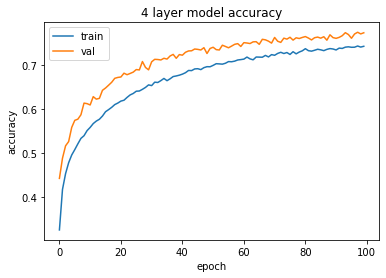

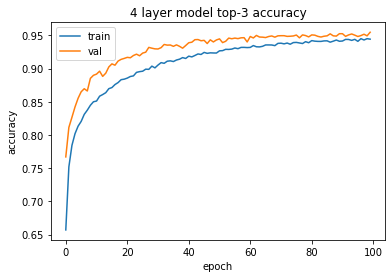

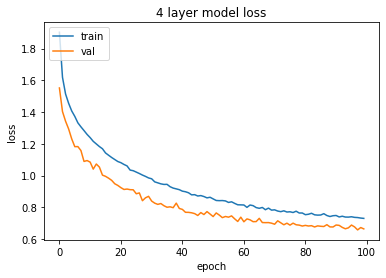

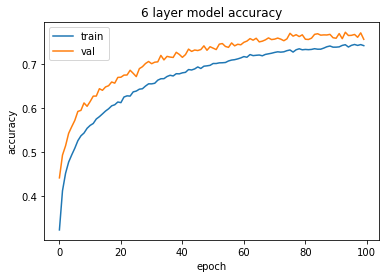

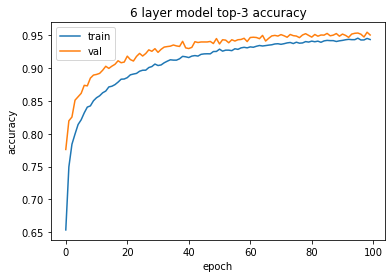

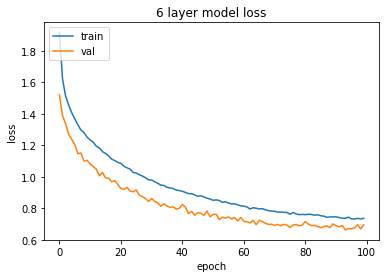

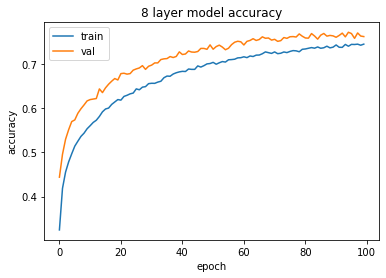

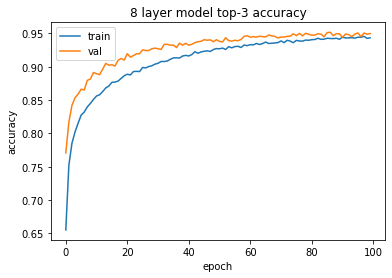

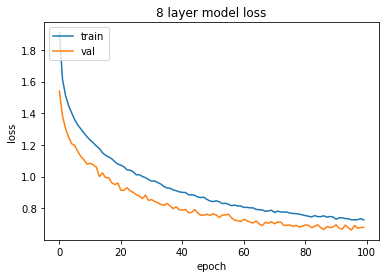

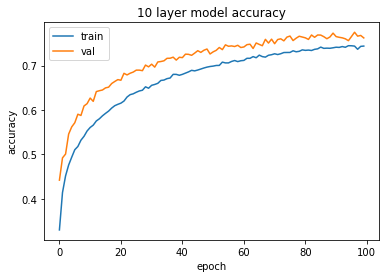

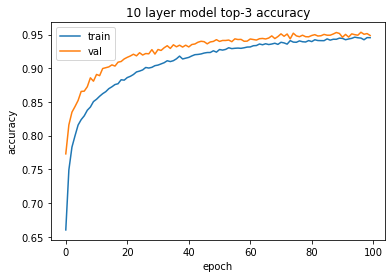

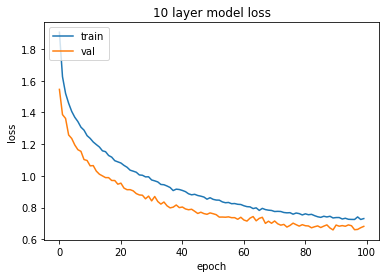

In [14]:
import matplotlib.pyplot as plt
for size in histories.keys():
    history = histories[size]
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{size} layer model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # top 5
    plt.plot(history.history['top-3-accuracy'])
    plt.plot(history.history['val_top-3-accuracy'])
    plt.title(f'{size} layer model top-3 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{size} layer model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


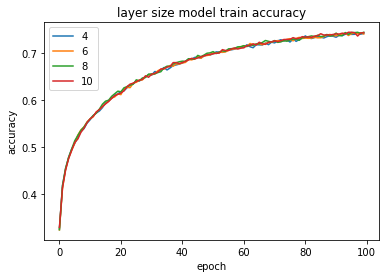

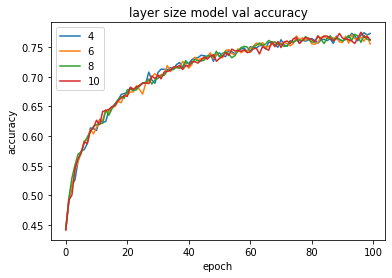

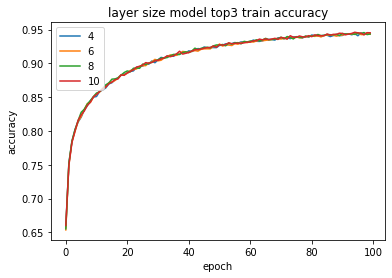

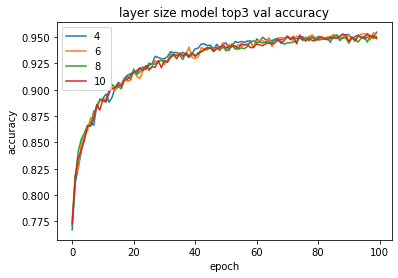

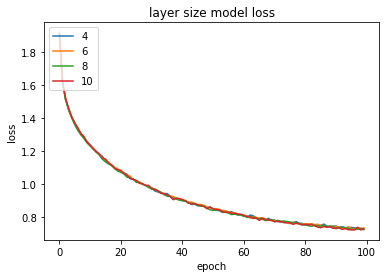

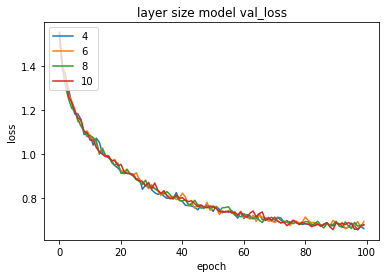

In [15]:
for size in histories.keys():
    history = histories[size]
    plt.plot(history.history['accuracy'])
plt.title(f'layer size model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(histories.keys(), loc='upper left')
plt.show()

for size in histories.keys():
    history = histories[size]
    plt.plot(history.history['val_accuracy'])

plt.title(f'layer size model val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(histories.keys(), loc='upper left')
plt.show()


for size in histories.keys():
    history = histories[size]
    plt.plot(history.history['top-3-accuracy'])
plt.title(f'layer size model top3 train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(histories.keys(), loc='upper left')
plt.show()

for size in histories.keys():
    history = histories[size]
    plt.plot(history.history['val_top-3-accuracy'])
plt.title(f'layer size model top3 val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(histories.keys(), loc='upper left')
plt.show()

for size in histories.keys():
    history = histories[size]
    plt.plot(history.history['loss'])
plt.title(f'layer size model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(histories.keys(), loc='upper left')
plt.show()

for size in histories.keys():
    history = histories[size]
    plt.plot(history.history['val_loss'])
plt.title(f'layer size model val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(histories.keys(), loc='upper left')
plt.show()

In [16]:
print(results)

{4: (0.7699999809265137, 0.9463000297546387), 6: (0.7608000040054321, 0.9451000094413757), 8: (0.7653999924659729, 0.9444000124931335), 10: (0.763700008392334, 0.9476000070571899)}


[array([0, 1]), [0.25, 1.25], [0.5, 1.5], [0.75, 1.75]]


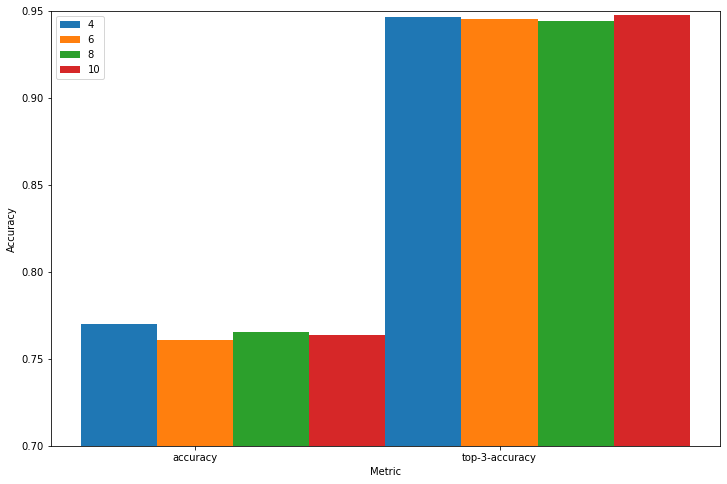

In [17]:
columns = results.keys()
rows = ['accuracy', 'top-3-accuracy']

barWidth=0.25
fig, ax = plt.subplots(figsize=(12,8))

bars = []

accs=[]
top3accs = []
labels = []

for col in columns:
    accs.append(results[col][0])
    top3accs.append(results[col][1])
    labels.append(col)


i=0
for c in columns:
    if i == 0:
        bar = np.arange(len(results[c]))
    else:
        bar = [x + barWidth for x in bars[i-1]]
    i+=1
    bars.append(bar)
print(bars)

i = 0
for c in columns:
    plt.bar(bars[i], results[c], width=barWidth, label=c)
   
    i += 1
plt.legend()
plt.xlabel('Metric')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth for r in range(len(rows))], rows)
plt.ylim(0.7,0.95)
plt.show()


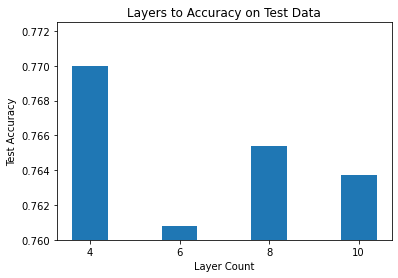

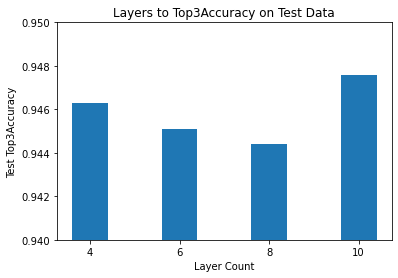

In [22]:
plt.bar(columns, accs)
plt.ylim((0.76, 0.7725))
plt.xticks(labels)
plt.ylabel('Test Accuracy')
plt.xlabel('Layer Count')
plt.title('Layers to Accuracy on Test Data')
plt.show()

plt.bar(columns, top3accs)
plt.ylim((0.94, 0.95))
plt.xticks(labels)
plt.ylabel('Test Top3Accuracy')
plt.xlabel('Layer Count')
plt.title('Layers to Top3Accuracy on Test Data')
plt.show()